In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import copy
import warnings
warnings.filterwarnings("ignore")
plotly.offline.init_notebook_mode (connected = True)

In [15]:
data=pd.read_csv('spotifytoptracks.csv')
data.head()

,Artist,Album,Track Name,Track Id,Energy,Danceability,Key,Loudness,Acousticness,Speechiness,Instrumentalness,Liveness,Valence,Tempo,Song Duration,Genre
0,The Weeknd,After Hours,Blinding Lights,0VjIjW4GlUZAMYd2vXMi3b,0.789938,-1.638549,-1.285498,0.125488,-0.970148,-0.556431,-0.169943,-0.611159,-1.035005,2.039582,0.002515,R&B/Soul
1,Tones And I,Dance Monkey,Dance Monkey,1rgnBhdG2JDFTbYkYRZAku,-0.106678,0.875208,0.076258,-0.075275,1.644400,-0.219242,-0.169241,-0.151869,-0.073339,-0.859023,0.291184,Alternative/Indie
2,Roddy Ricch,Please Excuse Me For Being Antisocial,The Box,0nbXyq5TXYPCO7pr3N8S4I,-0.152490,1.449088,1.165663,-0.198226,-0.579645,-0.590150,-0.170965,3.394333,0.402826,-0.108089,-0.098126,Hip-Hop/Rap
3,SAINt JHN,Roses (Imanbek Remix),Roses - Imanbek Remix,2Wo6QQD1KMDWeFkkjLqwx5,0.731036,0.551895,0.620961,0.330549,-0.918964,-0.635973,-0.124694,0.505894,1.579233,0.090286,-0.705296,Dance/Electronic
4,Dua Lipa,Future Nostalgia,Don't Start Now,3PfIrDoz19wz7qK7tYeu62,1.202250,0.616557,1.438014,0.732935,-0.928866,-0.355847,-0.170965,-0.580273,0.575552,0.169302,-0.495190,Nu-disco


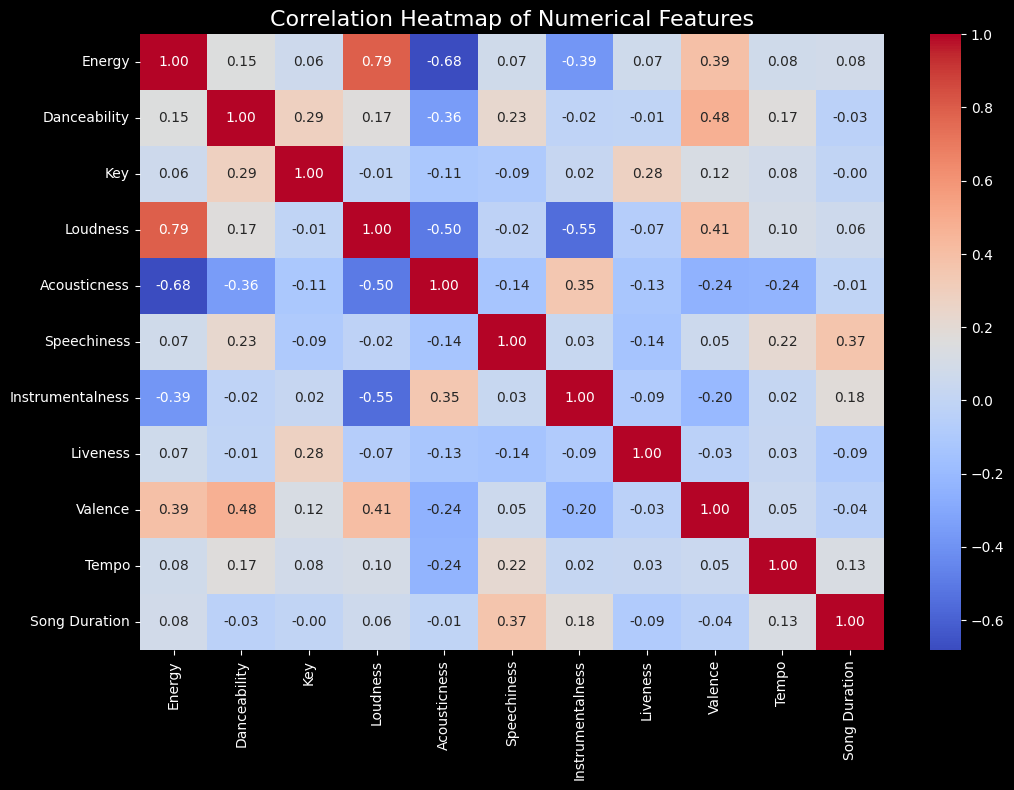

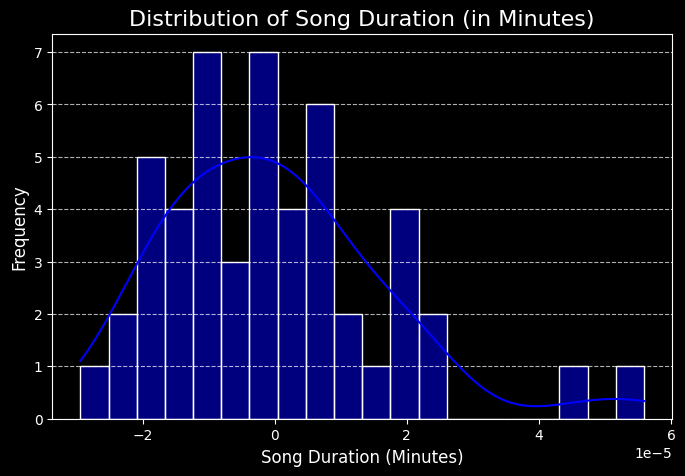

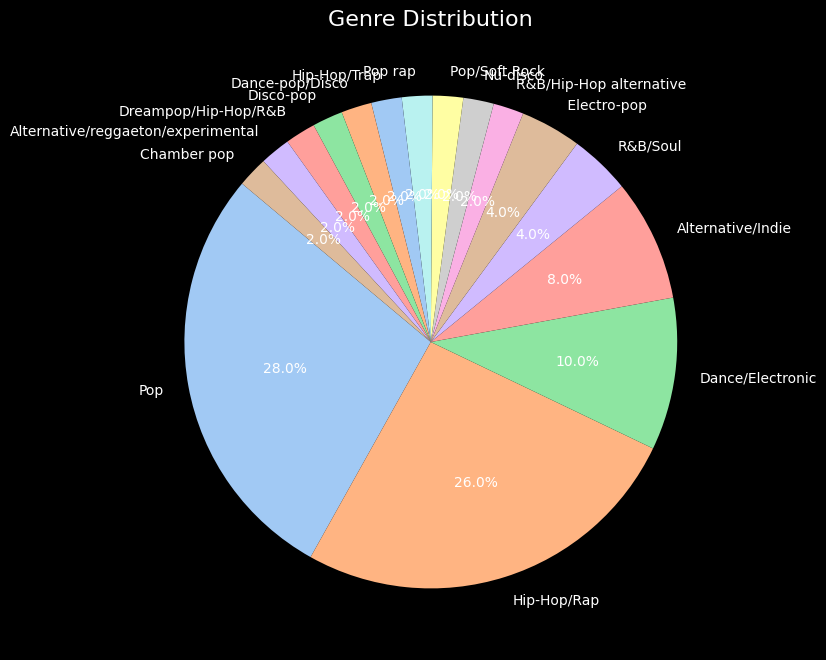

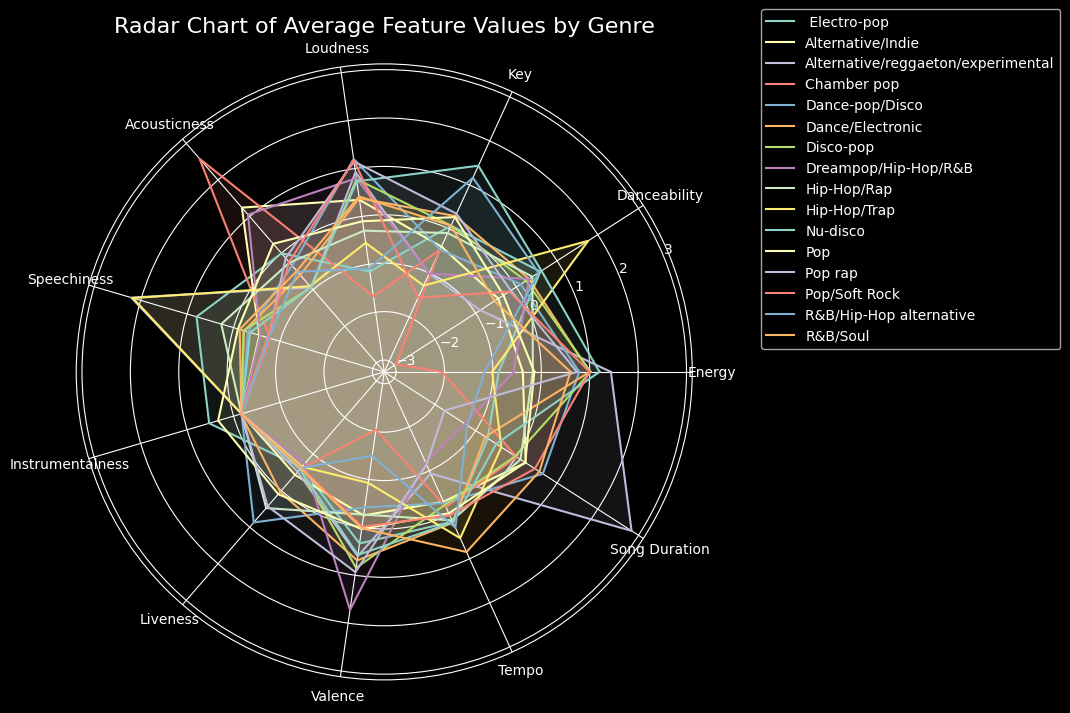

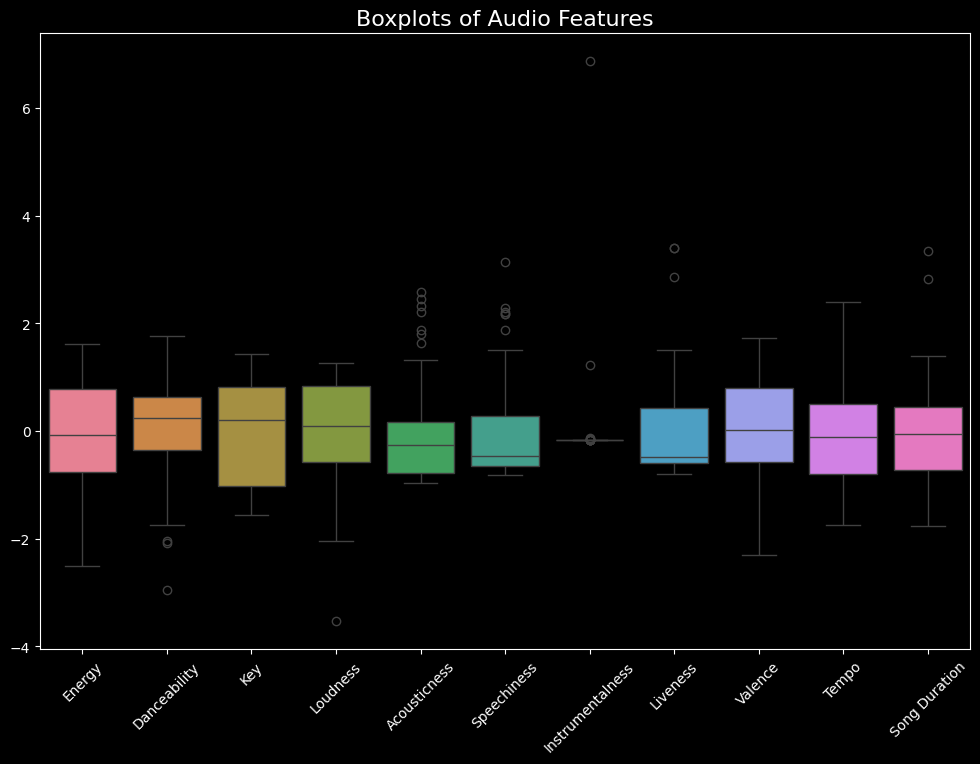

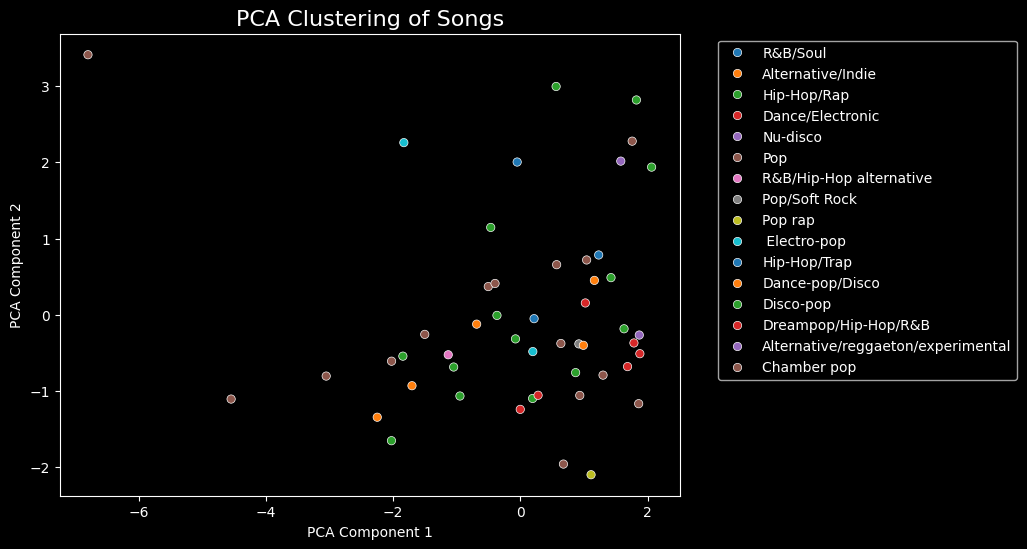

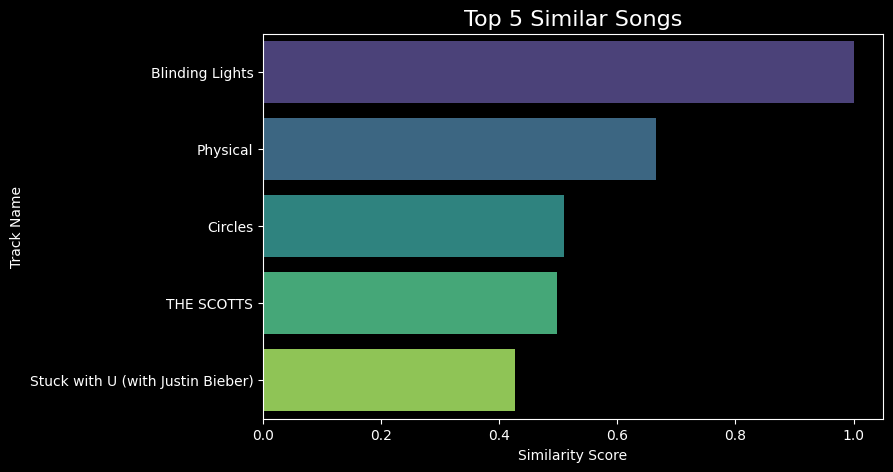

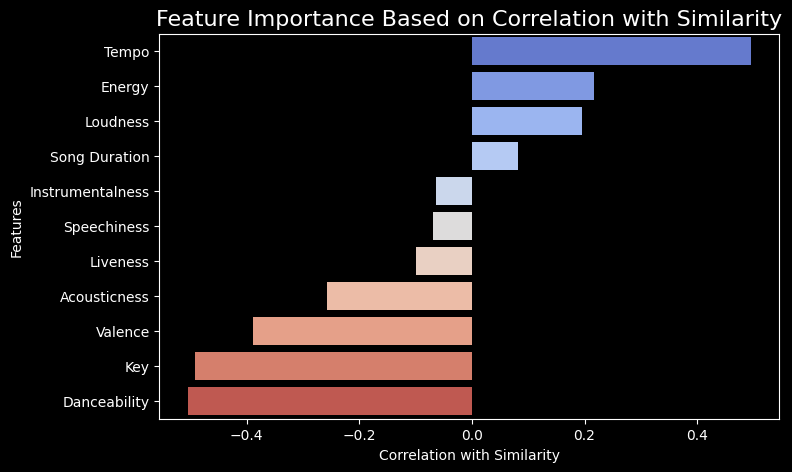

In [16]:
# Load the dataset
file_path = '/mnt/data/spotifytoptracks.csv'
data_cleaned = pd.read_csv('spotifytoptracks.csv')

# Numerical features for analysis
numerical_features = [
    'Energy', 'Danceability', 'Key', 'Loudness', 'Acousticness',
    'Speechiness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Song Duration'
]

# Step 1: Heatmap of Correlations
plt.figure(figsize=(12, 8))
correlation_matrix = data_cleaned[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Numerical Features", fontsize=16)
plt.show()

# Step 2: Distribution Plot for Song Duration
plt.figure(figsize=(8, 5))
sns.histplot(data_cleaned['Song Duration'] / 60000, bins=20, kde=True, color='blue')  # Convert ms to minutes
plt.title('Distribution of Song Duration (in Minutes)', fontsize=16)
plt.xlabel('Song Duration (Minutes)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Step 3: Genre Distribution Pie Chart
plt.figure(figsize=(8, 8))
genre_counts = data_cleaned['Genre'].value_counts()
plt.pie(genre_counts, labels=genre_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title('Genre Distribution', fontsize=16)
plt.show()

# Step 4: Radar Chart for Average Feature Values by Genre
genre_means = data_cleaned.groupby('Genre')[numerical_features].mean()
categories = list(genre_means.columns)
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(10, 8))
ax = plt.subplot(111, polar=True)
for genre, values in genre_means.iterrows():
    data = values.tolist()
    data += data[:1]
    ax.plot(angles, data, label=genre)
    ax.fill(angles, data, alpha=0.1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
plt.title('Radar Chart of Average Feature Values by Genre', fontsize=16)
plt.legend(bbox_to_anchor=(1.1, 1.1))
plt.show()

# Step 5: Boxplots for Outlier Detection
plt.figure(figsize=(12, 8))
sns.boxplot(data=data_cleaned[numerical_features])
plt.title("Boxplots of Audio Features", fontsize=16)
plt.xticks(rotation=45)
plt.show()

# Step 6: PCA for Clustering
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_cleaned[numerical_features])
data_cleaned['PCA1'] = pca_result[:, 0]
data_cleaned['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue=data_cleaned['Genre'], palette='tab10', data=data_cleaned)
plt.title('PCA Clustering of Songs', fontsize=16)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Step 7: Similarity Analysis
selected_song = data_cleaned.iloc[0][numerical_features].values.reshape(1, -1)
similarities = cosine_similarity(data_cleaned[numerical_features], selected_song).flatten()
data_cleaned['Similarity'] = similarities

top_similar = data_cleaned.nlargest(5, 'Similarity')[['Track Name', 'Similarity']]
plt.figure(figsize=(8, 5))
sns.barplot(data=top_similar, x='Similarity', y='Track Name', palette='viridis')
plt.title('Top 5 Similar Songs', fontsize=16)
plt.xlabel('Similarity Score')
plt.ylabel('Track Name')
plt.show()

# Step 8: Feature Importance (Correlation with Similarity)
feature_importance = data_cleaned[numerical_features].corrwith(data_cleaned['Similarity']).sort_values(ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette='coolwarm')
plt.title('Feature Importance Based on Correlation with Similarity', fontsize=16)
plt.xlabel('Correlation with Similarity')
plt.ylabel('Features')
plt.show()
